# **Production Engineering**

# *Reservoir Inflow Behaviour*

***

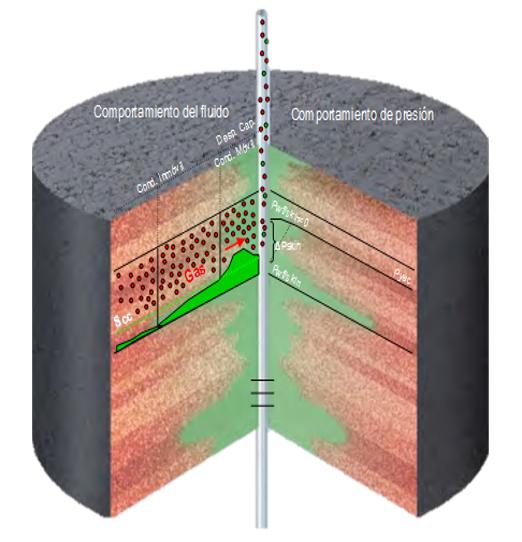

# Import Python Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

In [3]:
%config Completer.use_jedi = False

# **Important Functions**

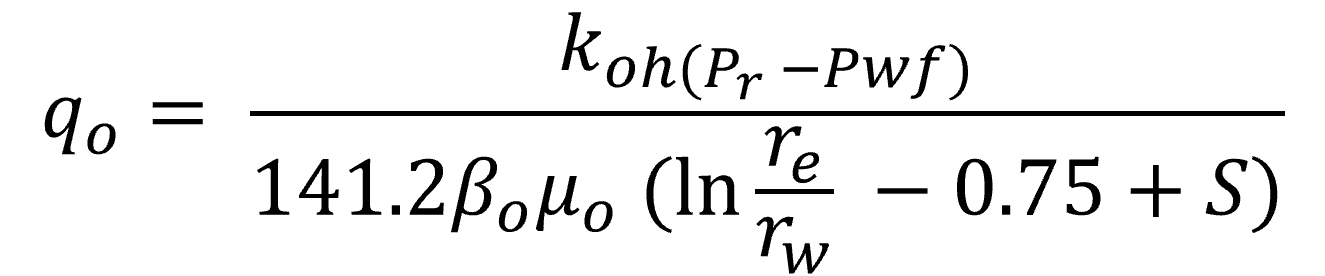

## **Productivity Index Taking into account Petrophysical and Fluid Properties**

$$J=\frac{K_{o}\,h}{141.2\,B_{o}\,u_{o}(\ln{\frac{r_{e}}{r_{w}}}-0.75+s)}$$

**Where:** \
*$J$:* Productivity Index (bpd/psi)\
*$K_{o}$:* Effective permeablity (md)\
*$h$:* Thickness (ft)\
*$B_{o}$:* Oil Formation Volume Factor (rb/stb)\
*$u_{o}$:* Oil Viscosity (cp)\
*$r_{e}$:* Drainage ratio (ft)\
*$r_{w}$:* Well ratio (ft)\
*$s$:* Skin

In [3]:
# Productivity Index (darcy law)
def j_darcy(ko, h, bo, uo, re, rw, s, flow_regime = 'seudocontinuo'):
    if flow_regime == 'seudocontinuo':
        J_darcy = ko * h / (141.2 * bo * uo * (np.log(re / rw) - 0.75 + s))
    elif flow_regime == 'continuo':
        J_darcy = ko * h / (141.2 * bo * uo * (np.log(re / rw) + s))
    return J_darcy

## **Productivity Index with productivity test data**

$$J=\frac{Q_{o}}{P_{r} - Pwf}$$ 

**Where:** \
*$J$:* Productivity Index (bpd/psi)\
*$Q_{o}$:* Oil Flow Rate (bpd)\
*$P_{r}$:* Reservoir Pressure (psia)\
*$Pwf$:* Pressure Well Flowing (psia)

In [4]:
# Productivity Index
def j(q_test, pwf_test, pr, pb, ef=1, ef2=None):
    if ef == 1:
        if pwf_test >= pb:
            J = q_test / (pr - pwf_test)
        else:
            J = q_test / ((pr - pb) + (pb / 1.8) * (1 - 0.2 * (pwf_test / pb) - 0.8 * (pwf_test / pb)**2))
    elif ef != 1 and ef2 is None:
        if pwf_test >= pb:
            J = q_test / (pr - pwf_test)
        else:
            J = q_test / ((pr - pb) + (pb / 1.8) * (1.8 * (1 - pwf_test / pb) - 0.8 * ef * (1 - pwf_test / pb)**2))
    elif ef !=1 and ef2 is not None:
        if pwf_test >= pb:
            J = (q_test / (pr - pwf_test) / ef) * ef2
        else:
            J = (q_test / ((pr - pb) + (pb / 1.8) * (1.8 * (1 - pwf_test / pb) - 0.8 * ef * (1 - pwf_test / pb)**2)) / ef) * ef2
    return J

## **Oil Flow Rate at Bubble Point**

$$Q_{b}=J(P_{r} - P_{b})$$

**Where:** \
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd) \
*$J$:* Productivity Index (bpd/psi) \
*$P_{r}$:* Reservoir Pressure (psia) \
*$P_{b}$:* Bubble Point Pressue

In [5]:
# Q(bpd) @ Pb 
def Qb(q_test, pwf_test, pr, pb, ef=1, ef2=None):
    qb = j(q_test, pwf_test, pr, pb, ef, ef2) * (pr - pb)
    return qb

## **AOF at different conditions**

**If $P_{r}$ > $P_{b}$** -> The oil reservoir is **UNDERSATURATED:** 

At this case, there are 2 conditions: 

*- If $Pwf$ >= $P_{b}$*: 
$$AOF=JP_{r}$$ 

*Otherwise*, 
$$AOF=Q_{b} + \frac{JP_{b}}{1.8}$$

On the other hand, if $P_{r}$ <= $P_{b}$ -> The oil reservoir is **SATURATED:** 

At this situation:

$$AOF=\frac{Qo_{test}}{1 - 0.2 (\frac{Pwf_{test}}{P_{r}}) - 0.8 (\frac{Pwf_{test}}{P_{r}})^2}$$

**Where:** \
*$AOF$:* Absolute Open Flow (bpd)\
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd)\ 
*$J$:* Productivity Index (bpd/psi)\
*$P_{r}$:* Reservoir Pressure (psia)\
*$P_{b}$:* Bubble Point Pressue\
*$Pwf$:* Pressure Well Flowing (psia)\
*$Pwf_{test}$:* Pressure Well Flowing of productity test (psia)\
*$Qo_{test}$:* Oil Flow Rate of productivity test (bpd)

In [80]:
# AOF(bpd)
def aof(q_test, pwf_test, pr, pb, ef=1, ef2=None):
    if (ef == 1 and ef2 is None):
        if pr > pb: # Yac. subsaturado
            if pwf_test >= pb:
                AOF = j(q_test, pwf_test, pr, pb) * pr
            elif pwf_test <  pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef=1) + ((j(q_test, pwf_test, pr, pb) * pb) / (1.8))
        else: # Yac. Saturado
            AOF = q_test / (1 - 0.2 * (pwf_test / pr) - 0.8 * (pwf_test / pr)**2)
    elif (ef < 1 and ef2 is None):
        if pr > pb:
            if pwf_test >= pb:
                AOF = j(q_test, pwf_test, pr, pb, ef) * pr
            elif pwf_test < pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef) + ((j(q_test, pwf_test, pr, pb, ef) * pb) / (1.8)) * (1.8 - 0.8 * ef)
        else:
            AOF = q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2) * (1.8 * ef - 0.8 * ef**2)
    elif (ef > 1 and ef2 is None):
        if pr > pb:
            if pwf_test >= pb:
                AOF = j(q_test, pwf_test, pr, pb, ef) * pr
            elif pwf_test < pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef) +  ((j(q_test, pwf_test, pr, pb, ef) * pb) / (1.8)) * (0.624 + 0.376 * ef)
        else:
            AOF = q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2) * (0.624 + 0.376 * ef)
    elif (ef < 1 and ef2 >= 1):
        if pr > pb:
            if pwf_test >= pb:
                AOF =  j(q_test, pwf_test, pr, pb, ef, ef2) * pr
            elif pwf_test < pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef, ef2) + (j(q_test, pwf_test, pr, pb, ef, ef2) * pb / 1.8) * (0.624 + 0.376 * ef2)
        else:
            AOF = q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2) * (0.624 + 0.376 * ef2)
    elif (ef > 1 and ef2 <= 1):
        if pr > pb:
            if pwf_test >= pb:
                AOF = j(q_test, pwf_test, pr, pb, ef, ef2) * pr
            elif pwf_test < pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef, ef2) + (j(q_test, pwf_test, pr, pb, ef, ef2) * pb / 1.8) * (1.8 - 0.8 * ef2)
        else:
            AOF = q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2) * (1.8 * ef - 0.8 * ef2**2)
    return AOF

## **$Q_{o}$ at Different Conditions**

Here, it is assumed that FE (Flow Efficiency) = 100% by using Vogel's statements.

**If $P_{r}$ > $P_{b}$** -> The oil reservoir is **UNDERSATURATED:** 

At this case, there are 2 conditions: 

*- If $Pwf$ >= $P_{b}$*: 
$$Q_{o}=J(P_{r} - Pwf)$$

*Otherwise*,
$$Q_{o}=Q_{b} + \frac{JP_{b}}{1.8}(1-0.2 (\frac{Pwf}{P_{b}})-0.8 (\frac{Pwf}{P_{b}})^2)$$

On the other hand, if $P_{r}$ <= $P_{b}$ -> The oil reservoir is **SATURATED:** 

At this situation:
$$Q_{o}=AOF(1-0.2 (\frac{Pwf}{P_{b}})-0.8 (\frac{Pwf}{P_{b}})^2)$$

**Where:** \
*$Q_{o}$:* Oil Flow Rate of productivity test (bpd)\
*$AOF$:* Absolute Open Flow (bpd)\
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd)\ 
*$J$:* Productivity Index (bpd/psi)\
*$P_{r}$:* Reservoir Pressure (psia)\
*$P_{b}$:* Bubble Point Pressue\
*$Pwf$:* Pressure Well Flowing (psia)

In [8]:
# Qo (bpd) @ Darcy Conditions
def qo_darcy(q_test, pwf_test, pr, pwf, pb):
    qo = j(q_test, pwf_test, pr, pb) * (pr - pwf)
    return qo

In [9]:
#Qo(bpd) @ vogel conditions
def qo_vogel(q_test, pwf_test, pr, pwf, pb):
    if pr > pb: # Yac. subsaturado
        if pwf >= pb:
            qo = qo_darcy(q_test, pwf_test, pr, pwf, pb)
        elif pwf < pb: 
            qo =  Qb(q_test, pwf_test, pr, pb) + ((j(q_test, pwf_test, pr, pb) * pb) / (1.8)) * \
            (1 - 0.2 * (pwf / pb) - 0.8 * ( pwf / pb)**2)
    elif pr <= pb: # Yac. Saturado
        qo = aof(q_test, pwf_test, pr, pb) * (1 - 0.2 * (pwf / pr) - 0.8 * ( pwf / pr)**2)
    return qo

In [83]:
# Qo (bpd) @ Standing conditions
def qo_standing(q_test, pwf_test, pr, pwf, pb, ef, ef2=None):
    if (ef < 1 and ef2 is None):
        if pr > pb:
            if pwf >= pb:
                qo = qo_darcy(q_test, pwf_test, pr, pwf, pb)
            elif pwf < pb:
                qo = Qb(q_test, pwf_test, pr, pb, ef) + ((j(q_test, pwf_test, pr, pb, ef) * pb) / (1.8)) * \
                (1.8 * (1 - pwf / pb) - 0.8 * ef * (1 - pwf / pb)**2)
        elif pr <= pb:
            qo = q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2) * \
            (1.8 * ef * (1 - pwf / pr) - 0.8 * ef**2 * (1 - pwf / pr)**2)
    elif (ef > 1 and ef2 is None):
        if pr > pb:
            if pwf >= pb:
                qo = qo_darcy(q_test, pwf_test, pr, pwf, pb)
            elif pwf < pb:
                qo = Qb(q_test, pwf_test, pr, pb, ef) + ((j(q_test, pwf_test, pr, pb, ef) * pb) / (1.8)) * \
            (1.8 * (1 - pwf / pb) - 0.8 * ef * (1 - pwf / pb)**2)
        elif pr <= pb:
            qo = q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2) * \
            (1.8 * ef * (1 - pwf / pr) - 0.8 * ef**2 * (1 - pwf / pr)**2)
    elif (ef < 1 and ef2 >= 1):
        if pr > pb:
            if pwf >= pb:
                qo = qo_darcy(q_test, pwf_test, pr, pwf, pb)
            elif pwf < pb:
                qo = Qb(q_test, pwf_test, pr, pb, ef, ef2) + ((j(q_test, pwf_test, pr, pb, ef, ef2) * pb) / (1.8)) * \
                (1.8 * (1 - pwf / pb) - 0.8 * ef2 * (1 - pwf / pb)**2)
        elif pr <= pb:
             qo = q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2) * \
                (1.8 * ef2 * (1 - pwf / pr) - 0.8 * ef2**2 * (1 - pwf / pr)**2)
    elif (ef > 1 and ef2 <= 1):
        if pr > pb:
            if pwf >= pb:
                qo = qo_darcy(q_test, pwf_test, pr, pwf, pb)
            elif pwf < pb:
                qo = Qb(q_test, pwf_test, pr, pb, ef, ef2) + ((j(q_test, pwf_test, pr, pb, ef, ef2) * pb) / (1.8)) * \
            (1.8 * (1 - pwf / pb) - 0.8 * ef2 * (1 - pwf / pb)**2)
        elif pr <= pb:
            qo = q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2) * \
            (1.8 * ef2 * (1 - pwf / pr) - 0.8 * ef2**2 * (1 - pwf / pr)**2)
    return qo

In [104]:
# Qo (bpd) @ any condition
def Qo(q_test, pwf_test, pr, pwf, pb, ef=1, ef2=None):
    if (ef == 1 and ef2 is None):
        if pr > pb:
            if pwf >= pb:
                qo = qo_darcy(q_test, pwf_test, pr, pwf, pb)
            elif pwf < pb:
                qo = qo_vogel(q_test, pwf_test, pr, pwf, pb)
        elif pr <= pb:
            qo = qo_vogel(q_test, pwf_test, pr, pwf, pb)
    elif ((ef < 1 or ef > 1) and ef2 is None):
        if pr > pb:
            if pwf >= pb:
                qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef)
            elif pwf < pb:
                qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef)
        elif pr <= pb:
            qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef)
    elif (ef < 1 and ef2 >= 1):
        if pr > pb:
            if pwf >= pb:
                qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef, ef2)
            elif pwf < pb:
                qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef, ef2)
        elif pr <= pb:
            qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef, ef2)
    elif (ef > 1 and ef2 <= 1):
        if pr > pb:
            if pwf >= pb:
                qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef, ef2)
            elif pwf < pb:
                qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef, ef2)
        elif pr <= pb:
            qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef, ef2)
    return qo

## **Pwf at Different Conditions**

Here, it is assumed that FE (Flow Efficiency) = 100% by using Vogel's statements.

**If $P_{r}$ > $P_{b}$** -> The oil reservoir is **UNDERSATURATED:** 

At this case, there are 2 conditions: 

*- If $Q_{o}$ <= $Q_{b}$*: 
$$Pwf=P_{r} - \frac{Q_{o}}{J}$$

*Otherwise*,
$$Pwf=0.125P_{r}(-1+ \sqrt{81-\frac{80Q_{o}}{Qo_{max}}})$$ ; $$Qo_{max}=Q_{b} + \frac{JP_{b}}{1.8}$$

On the other hand, if $P_{r}$ <= $P_{b}$ -> The oil reservoir is **SATURATED:** 

At this situation:
$$Pwf=0.125P_{r}(-1+ \sqrt{81-\frac{80Q_{o}}{Qo_{max}}})$$ ; $$Qo_{max}=\frac{Qo_{test}}{1 - 0.2 (\frac{Pwf_{test}}{P_{r}}) - 0.8 (\frac{Pwf_{test}}{P_{r}})^2}$$

**Where:** \
*$Q_{o}$:* Oil Flow Rate of productivity test (bpd)\
*$AOF = Qo_{max}$:* Absolute Open Flow (bpd)\
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd)\ 
*$J$:* Productivity Index (bpd/psi)\
*$P_{r}$:* Reservoir Pressure (psia)\
*$P_{b}$:* Bubble Point Pressue\
*$Pwf$:* Pressure Well Flowing (psia)\
*$Pwf_{test}$:* Pressure Well Flowing of productity test (psia)\
*$Qo_{test}$:* Oil Flow Rate of productivity test (bpd)

In [13]:
# Pwf @ vogel conditions
def pwf_vogel(q_test, pwf_test, pr, qo, pb):
    if pr > pb:
        if qo <= Qb(q_test, pwf_test, pr, pb):
            pwf = pr - qo / j(q_test, pwf_test, pr, pb)
        elif qo > Qb(q_test, pwf_test, pr, pb):
            Qmax = Qb(q_test, pwf_test, pr, pb) + ((j(q_test, pwf_test, pr, pb) * pb) / (1.8))
            pwf = 0.125*pr*(-1 + np.sqrt(81 - 80*qo/Qmax))
    elif pr <= pb:
        Qmax = q_test / (1 - 0.2 * (pwf_test / pr) - 0.8 * (pwf_test / pr)**2)
        pwf = 0.125*pr*(-1 + np.sqrt(81 - 80*qo/Qmax))
    return pwf    

## *Ejercicio 1*

In [14]:
# Data
ko = 8.2 #md
h = 53 #ft
bo = 1.2 #rb/stb
uo = 1.2 #cp
re = 2978.4 # ft
rw = 0.328 # ft
s = 0
pr = 5651 #psia

### a) J

In [15]:
j_Darcy = j_darcy(ko, h, bo, uo, re, rw, s)
print(f"J -> {j_Darcy} bpd/psia")

J -> 0.25555511281513077 bpd/psia


### b) AOF

In [16]:
AOF = j_Darcy * pr
print(f"AOF -> {AOF} bpd")

AOF -> 1444.141942518304 bpd


## *Ejercicio 2*

In [17]:
# Data
pr = 2400 #psia
pb = 2500 #psia
pwf = 1000 #psia
q_test = 100 #stb/d
pwf_test = 1800 #psia

### a) AOF

In [18]:
AOF_2 = aof(q_test, pwf_test, pr, pb)
print(f"AOF -> {AOF_2} bpd")

AOF -> 250.00000000000003 bpd


### b) IPR Curve

In [19]:
# Creating Dataframe
df = pd.DataFrame()

df['Pwf(psia)'] = np.array([2400, 2000, 1500, 1000, 500, 0])
df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_vogel(q_test, pwf_test, pr, x, pb))

In [20]:
df

,Pwf(psia),Qo(bpd)
0,2400,0.000000
1,2000,69.444444
2,1500,140.625000
3,1000,194.444444
4,500,230.902778
5,0,250.000000


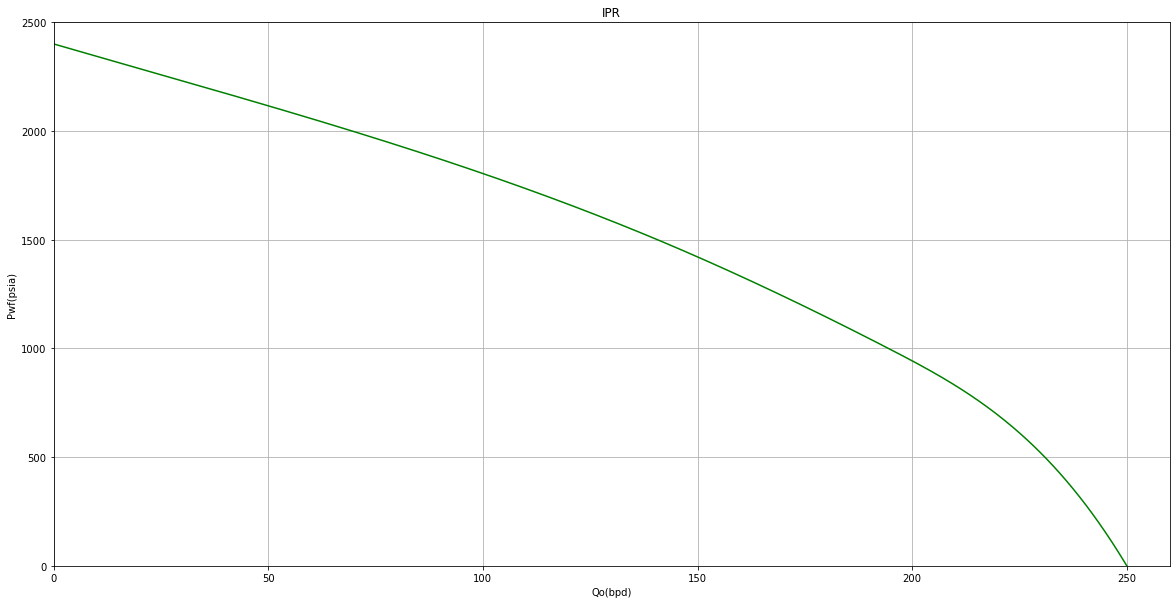

In [21]:
# Plot

fig, ax = plt.subplots(figsize=(20, 10))
x = df['Qo(bpd)']
y = df['Pwf(psia)']
X_Y_Spline = make_interp_spline(x, y) # This step is used to smooth the curve
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
ax.plot(X_, Y_, c='g')
ax.set_xlabel('Qo(bpd)')
ax.set_ylabel('Pwf(psia)')
ax.set_title('IPR')
ax.set(xlim=(0, df['Qo(bpd)'].max() + 10), ylim=(0, df['Pwf(psia)'][0] + 100))
ax.grid()
plt.show()

## *Ejercicio 3*

In [22]:
# Data
pr = 120 #bar
pb = 65 #bar
q_test = 400 #m3/d
pwf_test = 100 #bar
pwf = 40 #bar

### Qo @ Pwf=40 bar

In [23]:
qo_40 = qo_vogel(q_test, pwf_test, pr, pwf, pb)

In [24]:
print(f"qo -> {qo_40} stb/d")

qo -> 1514.5299145299145 stb/d


## *Ejercicio 4*

In [173]:
# Data
pr = 4000 #psi
pb = 3000 #psi
q_test = 600 #bpd
pwf_test = 2000 #bpd
pwf = np.array([4000, 3500, 3000, 2500, 1000, 0])

### a) Qmax

In [26]:
AOF_4 = aof(q_test, pwf_test, pr, pb)
print(f"AOF -> {AOF_4} stb/d")

AOF -> 864.0 stb/d


### b) Qo @ Pwf = 3500 psi

In [27]:
qo_3500 = qo_vogel(q_test, pwf_test, pr, 3500, pb)
print(f"Qo -> {qo_3500} stb/d")

Qo -> 162.0 stb/d


### c) Qo @ Pwf = 1000 psi

In [28]:
qo_1000 = qo_vogel(q_test, pwf_test, pr, 1000, pb)
print(f"Qo -> {qo_1000} stb/d")

Qo -> 780.0 stb/d


### d) Pwf @ Qo = 700 stb/d

In [29]:
print(f" Pwf -> {pwf_vogel(q_test, pwf_test, pr, 700, pb)} psi")

 Pwf -> 1511.5407766924084 psi


### e) IPR Curve

In [30]:
# IPR Curve
def IPR_curve(q_test, pwf_test, pr, pwf:list, pb):
    # Creating Dataframe
    df = pd.DataFrame()
    df['Pwf(psia)'] = pwf
    df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_vogel(q_test, pwf_test, pr, x, pb))
    fig, ax = plt.subplots(figsize=(20, 10))
    x = df['Qo(bpd)']
    y = df['Pwf(psia)']
    # The following steps are used to smooth the curve
    X_Y_Spline = make_interp_spline(x, y) 
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    #Build the curve
    ax.plot(X_, Y_, c='g')
    ax.set_xlabel('Qo(bpd)')
    ax.set_ylabel('Pwf(psia)')
    ax.set_title('IPR')
    ax.set(xlim=(0, df['Qo(bpd)'].max() + 10), ylim=(0, df['Pwf(psia)'][0] + 100))
    # Arrow and Annotations
    plt.annotate(
    'Bubble Point', xy=(Qb(q_test, pwf_test, pr, pb), pb),xytext=(Qb(q_test, pwf_test, pr, pb) + 100, pb + 100) ,
    arrowprops=dict(arrowstyle='->',lw=1)
    )
    # Horizontal and Vertical lines at bubble point
    plt.axhline(y=pb, color='r', linestyle='--')
    plt.axvline(x=Qb(q_test, pwf_test, pr, pb), color='r', linestyle='--')
    ax.grid()
    plt.show()

In [215]:
# IPR Curve
def IPR_curve(q_test, pwf_test, pr, pwf:list, pb, method, ef=1, ef2=None):
    # Creating Dataframe
    fig, ax = plt.subplots(figsize=(20, 10))
    df = pd.DataFrame()
    df['Pwf(psia)'] = pwf
    if method == 'Darcy':
        df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_darcy(q_test, pwf_test, pr, x, pb))
    elif method == 'Vogel':
        df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_vogel(q_test, pwf_test, pr, x, pb))
    elif method == 'Standing':
        if ef < 1:
             df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_standing(q_test, pwf_test, pr, x, pb, ef))
        elif ef > 1:
            df['Qo(bpd)'] = [qo_standing(q_test, pwf_test, pr, pwf, pb, ef) if p != 0 else \
                             aof(q_test, pwf_test, pr, pb, ef) for p in pwf]
    # Stand the axis of the IPR plot
    x = df['Qo(bpd)']
    y = df['Pwf(psia)']
    # The following steps are used to smooth the curve
    X_Y_Spline = make_interp_spline(x, y) 
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    #Build the curve
    ax.plot(X_, Y_, c='g')
    ax.set_xlabel('Qo(bpd)')
    ax.set_ylabel('Pwf(psia)')
    ax.set_title('IPR')
    ax.set(xlim=(0, df['Qo(bpd)'].max() + 10), ylim=(0, df['Pwf(psia)'].max() + 100))
    # Arrow and Annotations
    plt.annotate(
    'Bubble Point', xy=(Qb(q_test, pwf_test, pr, pb), pb),xytext=(Qb(q_test, pwf_test, pr, pb) + 100, pb + 100) ,
    arrowprops=dict(arrowstyle='->',lw=1)
    )
    # Horizontal and Vertical lines at bubble point
    plt.axhline(y=pb, color='r', linestyle='--')
    plt.axvline(x=Qb(q_test, pwf_test, pr, pb), color='r', linestyle='--')
    ax.grid()
    plt.show()

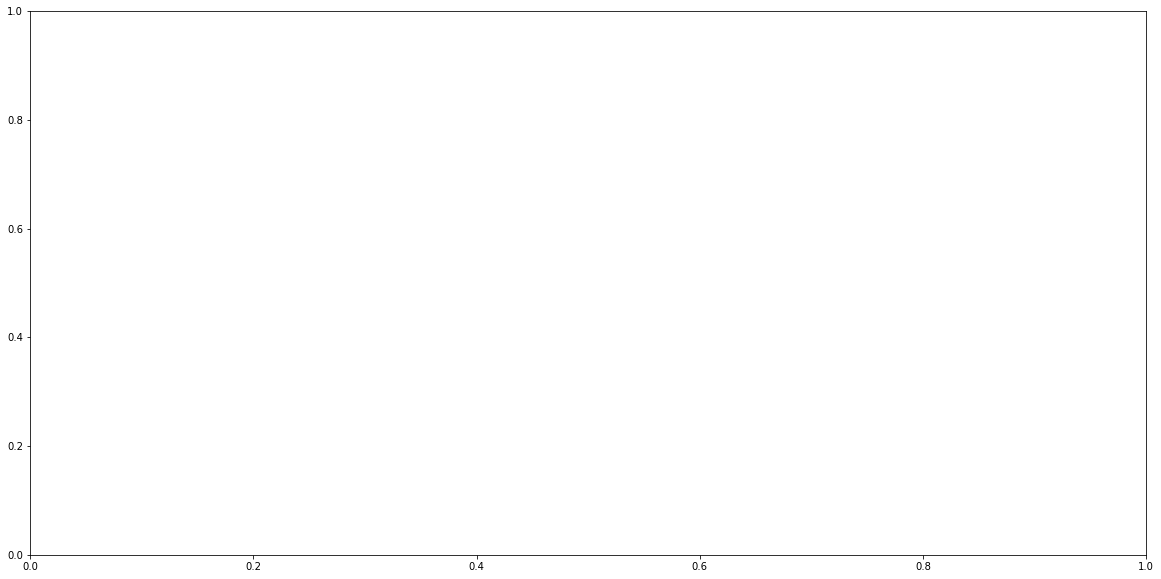

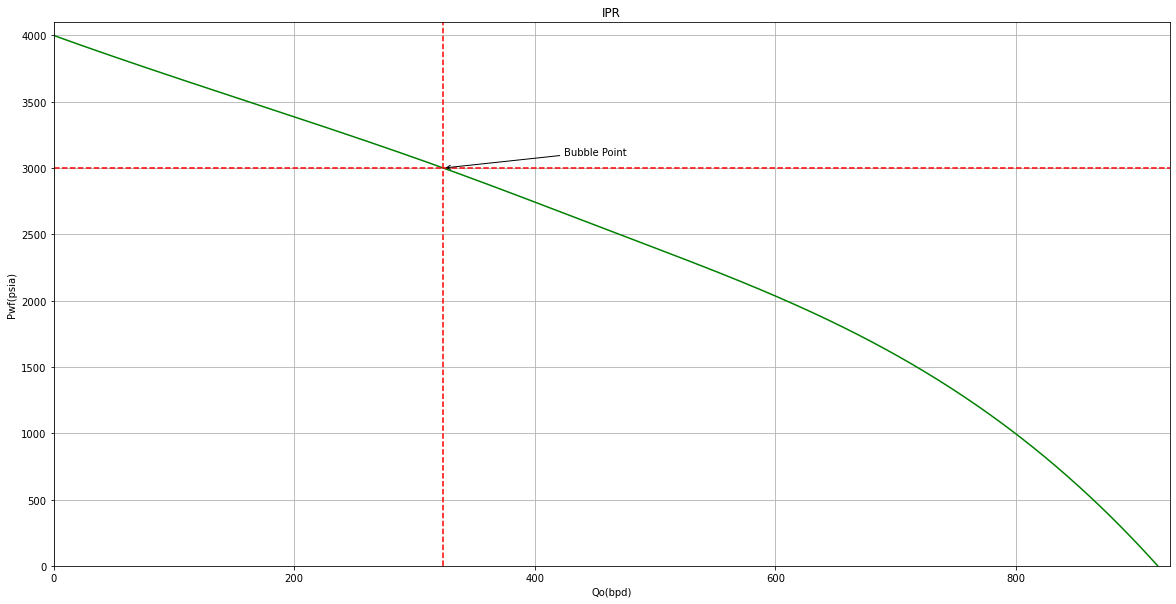

In [205]:
fig, ax = plt.subplots(figsize=(20, 10))

ax = IPR_curve(q_test, pwf_test, pr, pwf, pb, 'Standing', 0.85)
#IPR_curve(q_test, pwf_test, pr, pwf, pb, 'Vogel')
#IPR_curve(q_test, pwf_test, pr, pwf, pb, 'Darcy')

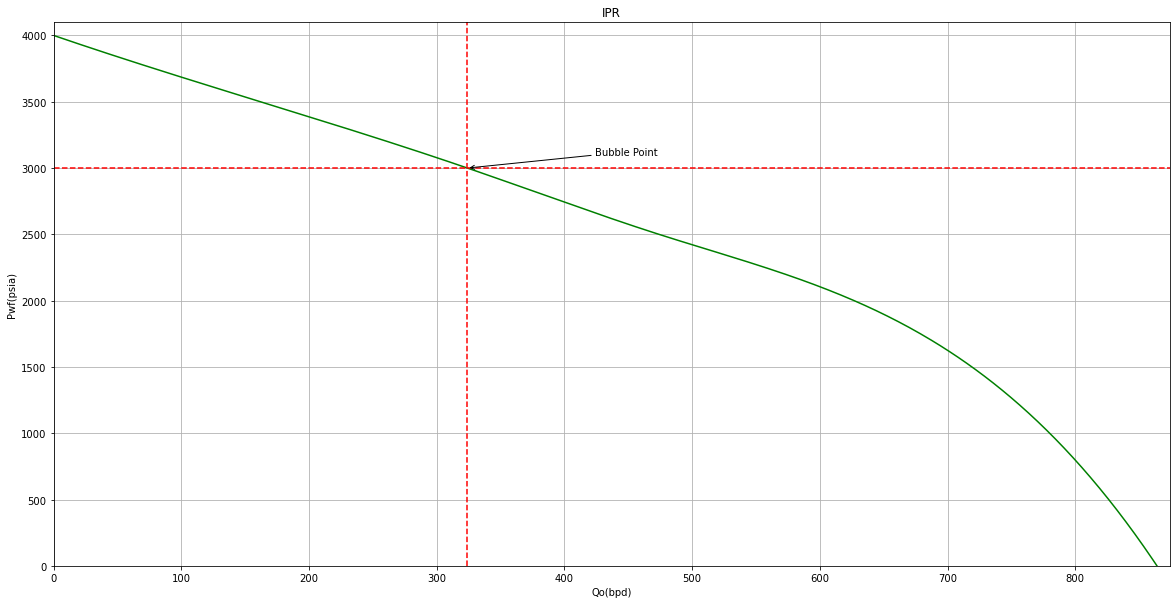

In [218]:
# IPR Curve Ex. 4
IPR_curve(q_test, pwf_test, pr, pwf, pb, 'Vogel')

## *Taller*

In [32]:
# Data
pr = 3000 #psig
pb = 2130 #psig
q_test = 631 #stb/d
pwf_test = 1700 #psig
pwf = np.array([3000, 2500, 2000, 1000, 0])

### a) Qb

In [33]:
Qb_t = Qb(q_test, pwf_test, pr, pb)

In [34]:
Qb_t

435.20039782642857

### b) AOF

In [35]:
AOF_t = aof(q_test, pwf_test, pr, pb)
print(f"AOF -> {AOF_t} stb/d")

AOF -> 1027.1396362493488 stb/d


### c) Qo @ 1000 psig

In [36]:
Qo_t = qo_vogel(q_test, pwf_test, pr, 1000, pb)
print(f"Qo -> {Qo_t} stb/d")

Qo -> 867.1807422233617 stb/d


### d) Pwf @ Qo=100 stb/d

In [37]:
print(f"Pwf -> {pwf_vogel(q_test, pwf_test, pr, 100, pb)} psig")

Pwf -> 2800.0920945051657 psig


### e) IPR Curve

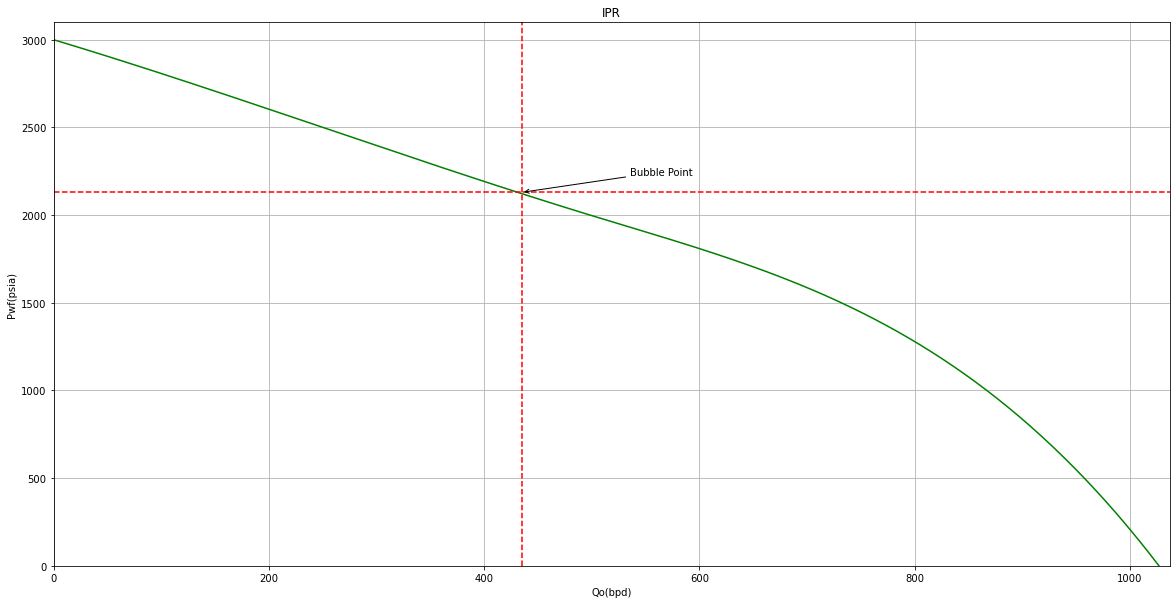

In [38]:
# IPR Curve Taller
IPR_curve(q_test, pwf_test, pr, pwf, pb)

In [728]:
x = np.array([300, 380, 450, 540])
y = np.array([2.72e6, 4.55e6, 6.508e6, 7.2e6])

In [729]:
from scipy.stats import linregress

19289.68824940048


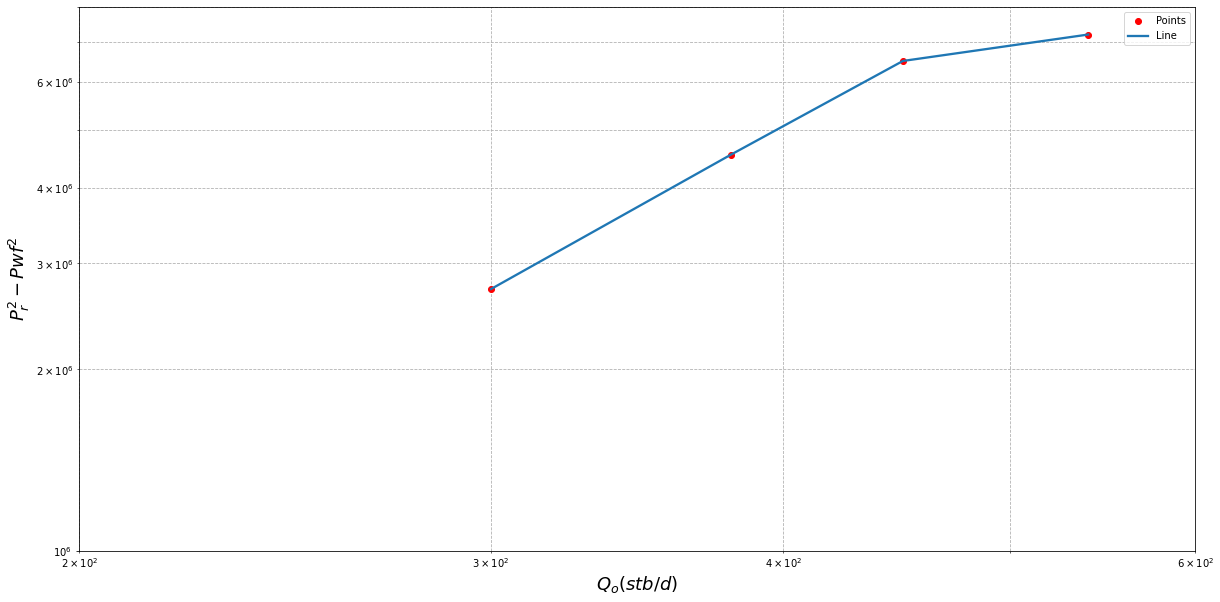

In [730]:
figure, ax2 = plt.subplots(figsize=(20,10))
ax2.plot(x,y, 'ok', c='red', linewidth=2.0, label='Points')
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(slope)
ax2.plot(x, y, linewidth=2.3, label='Line')
plt.xscale('log')
plt.yscale('log')
ax2.set_xlim(200, 600)
ax2.set_ylim(1e6, 8e6)
ax2.set_ylabel(r"$P_{r}^2 - Pwf^2$", fontsize=18)
ax2.set_xlabel(r"$Q_{o}(stb/d)$", fontsize=18)
plt.legend(loc='best')
ax2.grid(True,which="both", linestyle='--')
plt.show()